In [26]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from tools import *
from MakeSyntheticSeismic import MakeSeismic, PlotSeis
from ModelGenSeis import autoencoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import reduce_mean
from tensorflow.image import ssim
from tensorflow.keras.callbacks import EarlyStopping
from obspy.io.segy.segy import _read_segy
from obspy.io.segy.segy import _read_su
import tensorflow.keras.backend as K
import tensorflow as tf

In [32]:
data = _read_segy('./data/seismic/namss.B-11-88-AT.mcs.airgun/Data/SEGY/Stack/88-22-AA_stk.segy', headonly=True)
data_test = _read_segy('./data/seismic/namss.B-11-88-AT.mcs.airgun/Data/SEGY/Stack/88-22-G_stk.segy', headonly=True)

seis = np.stack(t.data for t in data.traces)
seis_test = np.stack(t.data for t in data_test.traces)

seis = seis[0:1536,0:1536]
seis_test = seis_test[0:1536,0:1536]

seis = seis/np.max(np.abs(seis))
seis_test = seis_test/np.max(np.abs(seis_test))


vm = np.percentile(seis, 99)
print("The 99th percentile is {:.0f}; the max amplitude is {:.0f}".format(vm, seis.max()))

The 99th percentile is 0; the max amplitude is 1


Text(0.5, 0, 'CMP (incrementing from 0)')

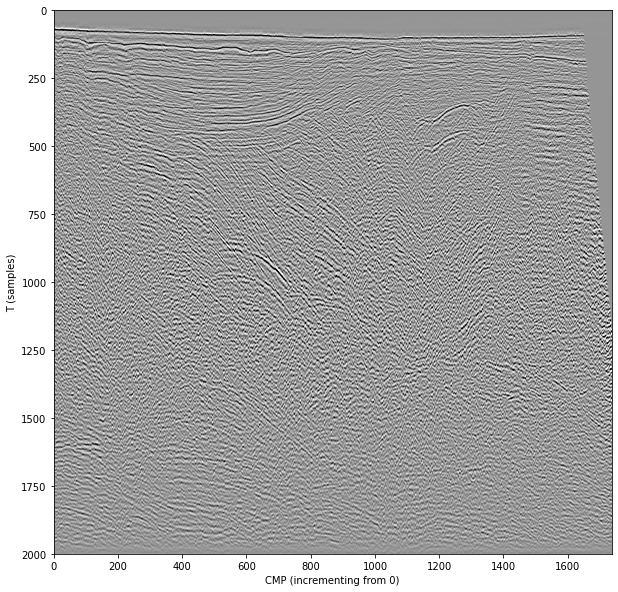

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(seis.T, cmap="Greys", vmin=-vm, vmax=vm, aspect='auto')
plt.ylabel('T (samples)')
plt.xlabel('CMP (incrementing from 0)')

In [35]:
# Reshaping traces before denoising
seis_trc_resh = seis.reshape(seis.shape[0]*6,256)

In [36]:
def correlation_coefficient_loss(y_true, y_pred):
    #optional
    #x = y_true - y_pred
    #y = y_pred
    #mx = K.mean(x)
    #my = K.mean(y)
    #xm, ym = x-mx, y-my
    #r_num = K.sum(tf.multiply(xm,ym))
    #r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    #r = r_num / r_den
    #r =  corr1 - (K.maximum(K.minimum(r, 1.0), -1.0))
    
    #1
    x1 = y_true
    y1 = y_pred
    mx1 = K.mean(x1)
    my1 = K.mean(y1)
    xm1, ym1 = x1-mx1, y1-my1
    r_num1 = K.sum(tf.multiply(xm1,ym1))
    r_den1 = K.sqrt(tf.multiply(K.sum(K.square(xm1)), K.sum(K.square(ym1))))
    r1 = r_num1 / r_den1
    r1 = 1 -  (K.maximum(K.minimum(r1, 1.0), -1.0))
    
    # Optional
    '''  
    x2 = y_true-y_pred
    y2 = y_true
    mx2 = K.mean(x2)
    my2 = K.mean(y2)
    xm2, ym2 = x2-mx2, y2-my2
    r_num2 = K.sum(tf.multiply(xm2,ym2))
    r_den2 = K.sqrt(tf.multiply(K.sum(K.square(xm2)), K.sum(K.square(ym2))))
    r2 = r_num2 / r_den2
    r2 =    corr3 - (K.maximum(K.minimum(r2, 1.0), -1.0))
    '''
    return   K.mean(K.square(y_true - y_pred)) + r1

In [55]:
# loading pre-trained models
from tensorflow.keras.models import load_model
modelANN_trc_SGD = load_model('./models/ANN_trc_SGD_p',compile=False)

In [62]:
modelANN_trc_SGD_2 = autoencoder("ANN")
modelANN_trc_SGD_2.compile(optimizer='adam',loss=[correlation_coefficient_loss])

In [64]:
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model

# load json and create model
json_file = open("./models/modelANN_trc_SGD.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
DDAE = model_from_json(loaded_model_json)

# load weights into new model
DDAE.load_weights("./models/modelANN_trc_SGD_weights.h5")
print("Loaded model from disk")


Loaded model from disk


In [56]:
modelANN_trc_SGD.compile(optimizer='adam',loss=[correlation_coefficient_loss])

In [57]:
batch_size=64
epochs=100
modelANN_trc_SGD.fit(seis_trc_resh,seis_trc_resh,batch_size=batch_size,epochs=epochs,shuffle=True)

Epoch 1/100
144/144 [==============================] - 1s 6ms/step - loss: 0.7720
Epoch 2/100
144/144 [==============================] - 1s 6ms/step - loss: 0.6879
Epoch 3/100
144/144 [==============================] - 1s 6ms/step - loss: 0.6501
Epoch 4/100
144/144 [==============================] - 1s 6ms/step - loss: 0.6277
Epoch 5/100
144/144 [==============================] - 1s 6ms/step - loss: 0.6080
Epoch 6/100
144/144 [==============================] - 1s 6ms/step - loss: 0.5934
Epoch 7/100
144/144 [==============================] - 1s 6ms/step - loss: 0.5794
Epoch 8/100
144/144 [==============================] - 1s 6ms/step - loss: 0.5674
Epoch 9/100
144/144 [==============================] - 1s 6ms/step - loss: 0.5558
Epoch 10/100
144/144 [==============================] - 1s 6ms/step - loss: 0.5451
Epoch 11/100
144/144 [==============================] - 1s 6ms/step - loss: 0.5352
Epoch 12/100
144/144 [==============================] - 1s 6ms/step - loss: 0.5285
Epoch 13/100


In [58]:
predANN_trc_SGD = modelANN_trc_SGD.predict(seis_trc_resh)

In [59]:
DecodedImgANN_trc_SGD = predANN_trc_SGD.reshape(1536,1536)

In [60]:
xmin = 200
xmax = 300
ymin = 400
ymax = 500

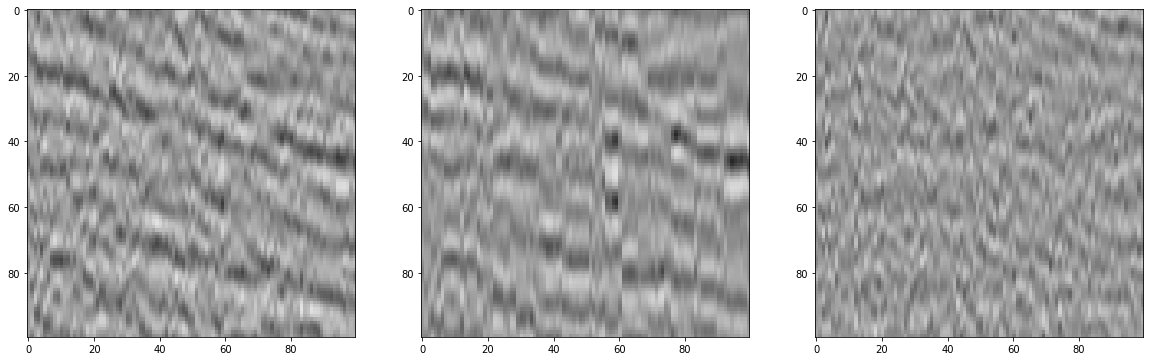

In [61]:
# PlotSeis([seis[xmin:xmax,ymin:ymax],DecodedImgANN_trc_SGD[xmin:xmax,ymin:ymax],seis[xmin:xmax,ymin:ymax]-DecodedImgANN_trc_SGD[xmin:xmax,ymin:ymax]])
plt.figure(figsize=(20,15))
plt.subplot(1,3,1)
plt.imshow(seis[xmin:xmax,ymin:ymax].T,vmin=-1,vmax=1,cmap='Greys')
plt.subplot(1,3,2)
plt.imshow(DecodedImgANN_trc_SGD[xmin:xmax,ymin:ymax].T,vmin=-1,vmax=1,cmap='Greys')
plt.subplot(1,3,3)
plt.imshow(seis[xmin:xmax,ymin:ymax].T-DecodedImgANN_trc_SGD[xmin:xmax,ymin:ymax].T,vmin=-1,vmax=1,cmap='Greys')